In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import networkx as nx

In [3]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [56]:
from src.nettack.GCN import *
from src.nettack.utils import *
from src.nettack.nettack import *

[autoreload of src.nettack.nettack failed: Traceback (most recent call last):
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    

# Tests

## Layers

In [5]:
layer = GraphConvolution(in_features=8, out_features=5)

In [6]:
N = 30
Adjacency_matrix = torch.tensor((np.random.rand(N, N) > 0.7).astype(np.float32)).to_sparse()
input = torch.rand(N, 8).to_sparse()

In [7]:
layer(input, Adjacency_matrix).shape

torch.Size([30, 5])

## GCN

In [8]:
N = 30
C = 5
D = 20
Adjacency_matrix = torch.tensor((np.random.rand(N, N) > 0.7).astype(np.float32)).to_sparse()

X_observed = torch.rand(N, D)
Y_observed = torch.randint(low=0, high=C, size=(N,))

H = 10

In [9]:
gcn = GCN(sizes=[H, C],
          An=Adjacency_matrix,
          X_obs=X_observed,
          name='test', with_relu=True, params_dict={})

In [10]:
gcn_model = GCN_Model(gcn, lr=1e-3)

In [11]:
node_ids = torch.tensor([1, 3, 7])
node_labels = torch.tensor([2, 0, 3])

In [12]:
train_nodes = [1, 2, 5, 6, 7, 9, 15]
val_nodes = [17, 18, 19, 20, 22]

In [13]:
gcn_model.train(split_train=train_nodes, split_val=val_nodes, Z_obs=Y_observed)

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


converged after 18 iterations


## Random

In [14]:
node_labels = pd.read_csv('datasets/citeseer/citeseer.node_labels', header=None, names=['id', 'label'])

In [15]:
edges = pd.read_csv('datasets/citeseer/citeseer.edges', header=None, names=['e1', 'e2', 'weight'])

In [16]:
G = nx.Graph()
for _, row in node_labels.iterrows():
    G.add_node(row.id, label=row.label)
G.add_edges_from(edges.loc[:, ['e1', 'e2']])

## Nettack

### Data preprocessing

In [17]:
_A_obs, _X_obs, _z_obs = load_npz('src/data/citeseer.npz')

In [18]:
# Adjacency matrix
_A_obs

<3312x3312 sparse matrix of type '<class 'numpy.float32'>'
	with 4715 stored elements in Compressed Sparse Row format>

In [19]:
# Feature matrix
_X_obs

<3312x3703 sparse matrix of type '<class 'numpy.int64'>'
	with 105165 stored elements in Compressed Sparse Row format>

In [20]:
np.array(_X_obs[0].todense())[0].shape

(3703,)

In [21]:
# Labels
_z_obs
pd.value_counts(_z_obs)

2    701
4    668
1    596
5    590
3    508
0    249
dtype: int64

In [22]:
# Normalizing Adjacency matrix
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1

In [23]:
# For the algorithm to work, we have to consider a connected graph.
lcc = largest_connected_components(_A_obs)

Selecting 1 largest connected components


In [24]:
print(f'Largest connected component has {len(lcc)} nodes')
# keeping the largest connected component of the graph
_A_obs = _A_obs[lcc][:,lcc]
_X_obs = _X_obs[lcc].astype('float32')
_z_obs = _z_obs[lcc]

Largest connected component has 2110 nodes


In [25]:
assert np.abs(_A_obs - _A_obs.T).sum() == 0, "Input graph is not symmetric"
assert _A_obs.max() == 1 and len(np.unique(_A_obs[_A_obs.nonzero()].A1)) == 1, "Graph must be unweighted"
assert _A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"

In [26]:
_N = _A_obs.shape[0]
_K = _z_obs.max()+1

# In our pytorch implementation, labels are not one hot encoded
# _Z_obs = np.eye(_K)[_z_obs]
_Z_obs = _z_obs
# Normalizing adjacency matrix
_An = preprocess_graph(_A_obs)
sizes = [16, _K]
degrees = _A_obs.sum(0).A1


np.random.seed(seed)

In [27]:
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
splits = train_val_test_split_tabular(np.arange(_N), train_size=train_share,
                                      val_size=val_share, test_size=unlabeled_share,
                                      stratify=_z_obs)
split_train, split_val, split_unlabeled = splits

In [28]:
print(f'Number of training node : {len(split_train)}')
print(f'Number of validation nodes : {len(split_val)}')
print(f'Number of unlabeled (unknown) nodes : {len(split_unlabeled)}')

Number of training node : 210
Number of validation nodes : 211
Number of unlabeled (unknown) nodes : 1688


### Choosing the node to attack

In [29]:
u = 0 # node to attack
assert u in split_unlabeled

### Train surrogate model

Initialization of Nettack : train on a simple model (with no ReLU) the weights of the GCN.

In [30]:
def sparse_numpy2sparse_torch(x):
    x = x.tocoo()
    values = x.data
    indices = np.vstack((x.row, x.col)).astype(float)
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = x.shape
    return torch.sparse.FloatTensor(i, v, torch.Size(shape))

In [31]:
An = sparse_numpy2sparse_torch(_An)
X_obs = sparse_numpy2sparse_torch(_X_obs)

In [32]:
surrogate_nn = GCN(sizes, An, X_obs, with_relu=False, name="surrogate")

In [33]:
surrogate_model = GCN_Model(surrogate_nn, lr=1e-2)

In [34]:
split_train = np.array(split_train).astype(np.int64)
split_val = np.array(split_val).astype(np.int64)

In [35]:
surrogate_model.train(split_train, split_val, torch.tensor(_Z_obs.astype(np.int64)), print_info=False)

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
preds = surrogate_model.predictions.detach().cpu().numpy().argmax(axis=1)
truth = _Z_obs[split_val]
(truth == preds).mean()

0.6255924170616114

In [37]:
W1 = surrogate_model.gcn.gc1.weight
W2 = surrogate_model.gcn.gc2.weight

### Setup attack

In [38]:
nettack = Nettack(_A_obs, _X_obs, _z_obs, W1, W2, u, verbose=True)

In [39]:
direct_attack = True
n_influencers = 1 if direct_attack else 5
n_perturbations = int(degrees[u]) # How many perturbations to perform. Default: Degree of the node
perturb_features = True
perturb_structure = True

### Poison the data

In [40]:
nettack.reset()

In [41]:
direct_attack = True
n_influencers = 1 if direct_attack else 5
n_perturbations = int(degrees[u]) # How many perturbations to perform. Default: Degree of the node
perturb_features = False
perturb_structure = True

### Poison the data

In [111]:
nettack.reset()

For M=25, the first two perturbations are done in a different order, the rest stays the same. For M=5, the modifications are the same. This proves that the look ahead algorithm is correct and can only improve the performance 

In [112]:
nettack.attack_surrogate(n_perturbations,
                         perturb_structure=perturb_structure,
                         perturb_features=perturb_features,
                         direct=direct_attack,
                         n_influencers=n_influencers,
                        look_ahead=True,
                         M=25)

##### Starting attack #####
##### Attack only using structure perturbations #####
##### Attacking the node directly #####
##### Performing 12 perturbations #####
Using the greedy look ahead algorithm
##### ...1/12 perturbations ... #####
##### ...3/12 perturbations ... #####
##### ...5/12 perturbations ... #####
##### ...7/12 perturbations ... #####
##### ...9/12 perturbations ... #####
##### ...11/12 perturbations ... #####


In [113]:
print(nettack.structure_perturbations)

[(0, 2012), (0, 1582), (0, 129), (0, 374), (0, 2095), (0, 751), (0, 1108), (0, 42), (0, 1677), (0, 1901), (0, 330), (0, 209)]


In [114]:
print(nettack.feature_perturbations)

[(), (), (), (), (), (), (), (), (), (), (), ()]


### Train GCN without perturbations

In [115]:
retrain_iters=5

In [116]:
classification_margins_clean = []
class_distrs_clean = []

u_nodes = torch.tensor([nettack.u])
u_labels = torch.tensor(_Z_obs.astype(np.int64))[u_nodes]
one_hot_encod_u = np.zeros(np.max(_Z_obs)+1)
one_hot_encod_u[_Z_obs[nettack.u]] = 1


for _ in range(retrain_iters):
    print("... {}/{} ".format(_+1, retrain_iters))
    gcn_before_nn = GCN(sizes, An, X_obs, with_relu=True,
                   name="gcn_orig")
    gcn_before = GCN_Model(gcn_before_nn, lr=1e-2)
    gcn_before.train(split_train, split_val, torch.tensor(_Z_obs.astype(np.int64)), print_info=False)
    preds = gcn_before.predictions.detach().cpu().numpy().argmax(axis=1)
    truth = _Z_obs[split_val]
    print(f'Validation accuracy : {(truth == preds).mean():.3f}')
    gcn_before._compute_loss_and_backprop(u_nodes, u_labels, False)
    probs_before_attack = gcn_before.predictions.detach().cpu().numpy()[0]

    class_distrs_clean.append(probs_before_attack)
    best_second_class_before = (probs_before_attack - 1000*one_hot_encod_u).argmax()
    margin_before = probs_before_attack[_z_obs[nettack.u]] - probs_before_attack[best_second_class_before]
    classification_margins_clean.append(margin_before)
class_distrs_clean = np.array(class_distrs_clean)

... 1/5 


/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy : 0.668
... 2/5 
Validation accuracy : 0.664
... 3/5 
Validation accuracy : 0.664
... 4/5 
Validation accuracy : 0.649
... 5/5 
Validation accuracy : 0.678


### Train GCN with perturbations

In [117]:
classification_margins_corrupted = []
class_distrs_retrain = []

nettack_adj_torch = sparse_numpy2sparse_torch(nettack.adj_preprocessed)
nettack_X_torch = sparse_numpy2sparse_torch(nettack.X_obs.tocsr())

for _ in range(retrain_iters):
    print("... {}/{} ".format(_+1, retrain_iters))
    gcn_retrain_nn = GCN(sizes, nettack_adj_torch, nettack_X_torch, with_relu=True,
                   name="gcn_retrain")
    gcn_retrain = GCN_Model(gcn_retrain_nn, lr=1e-2)

    gcn_retrain.train(split_train, split_val, torch.tensor(_Z_obs.astype(np.int64)), print_info=False)
    gcn_retrain._compute_loss_and_backprop(u_nodes, u_labels, False)
    probs_after_attack = gcn_retrain.predictions.detach().cpu().numpy()[0]
    class_distrs_retrain.append(probs_after_attack)
    best_second_class_after = (probs_after_attack - 1000*one_hot_encod_u).argmax()
    margin_after = probs_after_attack[_z_obs[nettack.u]] - probs_after_attack[best_second_class_after]
    classification_margins_corrupted.append(margin_after)
class_distrs_retrain = np.array(class_distrs_retrain)

... 1/5 
... 2/5 
... 3/5 
... 4/5 
... 5/5 


### Visualize results

In [118]:
classification_margins_corrupted, classification_margins_clean

([-0.99973446, -0.9958911, -0.99816126, -0.9948137, -0.9995308],
 [0.95503354, 0.9742912, 0.9695786, 0.9715423, 0.9720526])

<IPython.core.display.Javascript object>


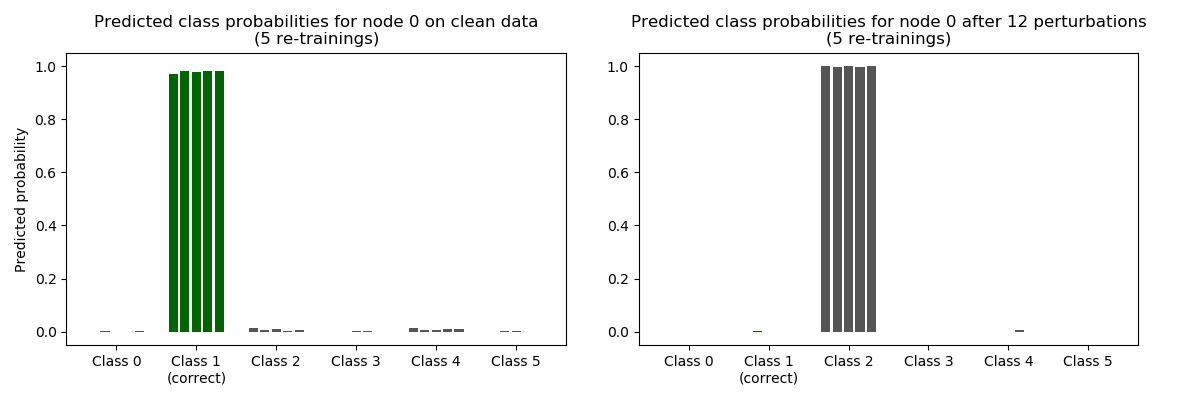

In [119]:
def make_xlabel(ix, correct):
    if ix==correct:
        return "Class {}\n(correct)".format(ix)
    return "Class {}".format(ix)

figure = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(class_distrs_clean.T):
    x_ixs= np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = '#555555'
    if ix == nettack.label_u:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)

ax=plt.gca()
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel(k, nettack.label_u) for k in range(_K)])
ax.set_title("Predicted class probabilities for node {} on clean data\n({} re-trainings)".format(nettack.u, retrain_iters))

fig = plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(class_distrs_retrain.T):
    x_ixs= np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = '#555555'
    if ix == nettack.label_u:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)


ax=plt.gca()
plt.ylim((-.05, 1.05))
ax.set_xticks(center_ixs_retrain)
ax.set_xticklabels([make_xlabel(k, nettack.label_u) for k in range(_K)])
ax.set_title("Predicted class probabilities for node {} after {} perturbations\n({} re-trainings)".format(nettack.u, n_perturbations, retrain_iters))
plt.tight_layout()
plt.show()